<a href="https://colab.research.google.com/github/sgalrot/simpsons_compression/blob/main/simpsons_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simpsons Images Compression

### Some Colab Setup

Installing kaggle and downloading the dataset

You should download the **kaggle.json** file from your kaggle account and upload it once prompted with "upload file"

In case you are using local machine, just (not tested):

1) `pip install`

2) download dataset using `kaggle datasets download -d kostastokis/simpsons-faces`

In [ ]:
from os.path import exists, expanduser
if not exists(expanduser('~/.kaggle/kaggle.json')):
  !pip install -q kaggle # type: ignore
  from google.colab import files 
  files.upload()
  !mkdir ~/.kaggle # type: ignore
  !cp kaggle.json ~/.kaggle/ # type: ignore
  !chmod 600 ~/.kaggle/kaggle.json # type: ignore

# Downloading the dataset
!kaggle datasets download -d kostastokis/simpsons-faces
!mkdir dataset
!unzip simpsons-faces.zip -d ./dataset/

### Importing Packages

Importing the NumPy, Pandas and Matplotlib, PyTorch Scikit-Image etc. packages.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import torch
from torchvision import datasets
from skimage.transform import resize
from skimage.io import imread, imsave


## This line makes matplotlib plot the figures inside the notebook
%matplotlib inline

## Set some default values of the the matplotlib plots
plt.rcParams['figure.figsize'] = (8.0, 8.0)  # Set default plot's sizes
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## Loading the Dataset

We will use again the digits dataset from the last assignment.

In [ ]:
from os.path import split
import glob
path = 'dataset'
path_img = list(glob.glob(path+'/cropped/*.png'))

labels = list(map(lambda x:split(split(x)[0])[1], path_img))
file_path = pd.Series(path_img, name='File_Path').astype(str)

# labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path
0,dataset/cropped/3690.png
1,dataset/cropped/6854.png
2,dataset/cropped/7379.png
3,dataset/cropped/5280.png
4,dataset/cropped/2030.png


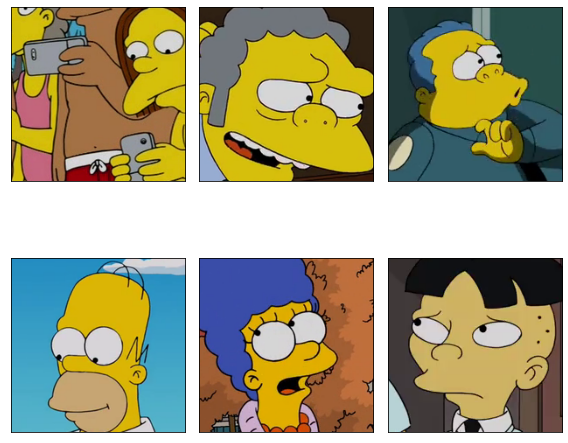

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(imread(data.File_Path[i]))
plt.tight_layout()
plt.show()

In [ ]:
images = data.File_Path
type(images) 

pandas.core.series.Series

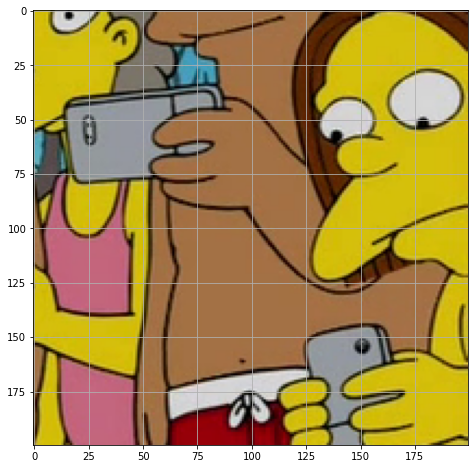

In [ ]:
image_sample = imread(images[0])
plt.imshow(image_sample)
x_dim, y_dim, _ = image_sample.shape

In [ ]:
image_resize_shape = (64, 64, 3)
x = np.array([resize(imread(file_path), image_resize_shape, anti_aliasing=True) 
                for file_path in data.File_Path])

## Train-Test split

In [ ]:
n_samples = x.shape[0]  # The total number of samples in the dataset

## Generate a random generator with a fixed seed
rand_gen = np.random.RandomState(0)

## Generating a shuffled vector of indices
indices = np.arange(n_samples)
rand_gen.shuffle(indices)

## Split the indices into 90% train / 10% test
train_indices = indices[:int(0.9 * n_samples)]
test_indices = indices[int((0.9) * n_samples):]


## Extract the sub datasets from the full dataset using the calculated indices
x_train = x[train_indices]
x_test = x[test_indices]

## Naive PCA Compression
We will try first, a naive PCA fit, in order to do it we first resize the images into 64\*64\*3 since we don't have enough RAM to run the original size


In [ ]:
from sklearn.decomposition import PCA
image_resize_shape = (64, 64, 3)

def image_to_resized_vector_transform(image_path):
  image = resize(imread(image_path), image_resize_shape, anti_aliasing=True)
  return image.reshape(-1)

X = x_train.reshape(x_train.shape[0], -1)

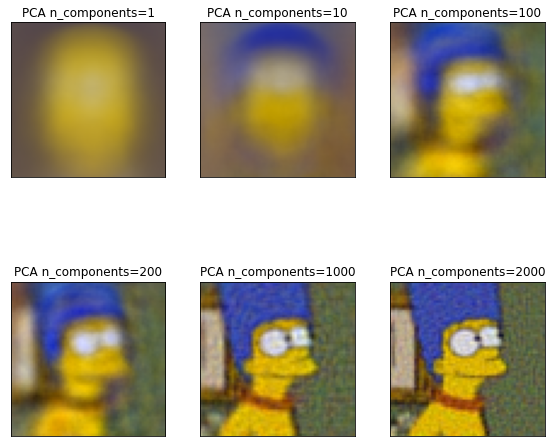

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
n_components = [1, 10, 100, 200, 1000, 2000]
for i, ax in enumerate(axes.flat):
    pca = PCA(n_components=n_components[i])
    pca.fit(X)
    reconstructed_image = pca.inverse_transform(pca.transform(x_test[0:1].reshape(1,-1)))
    ax.imshow(reconstructed_image.reshape(image_resize_shape))
    ax.set_title("PCA n_components={}".format(n_components[i]))
plt.tight_layout()
plt.show()

We see some noise even when n_components=2000, compression ratio in this case is ~ 64\*3\*3\/2000 = 6
In a standard jpeg compression we get ~ 8.4 compression ratio for the same picture.

In [ ]:
from skimage.io import imsave, imread


imsave('compressed.jpg', X[0].reshape(image_resize_shape))
jpg_image = imread('compressed.jpg')
reconstructed_pca_image = pca.inverse_transform(pca.transform(X[0:1]))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
title = ["original", "pca", "jpg"]
images_to_show = [X[0].reshape(image_resize_shape), reconstructed_pca_image.reshape(image_resize_shape), jpg_image]
for i, ax in enumerate(axes.flat):
    ax.imshow(images_to_show[i])
    ax.set_title(title[i])
plt.tight_layout()
plt.show()
print(">>> ls -l compressed.jpg")
!ls -l compressed.jpg

NameError: ignored

#Building Autoencoder

In [ ]:
class CNN_AE(torch.nn.Module):

    def __init__(self):   
        super(CNN_AE, self).__init__()
        
        ## Defining the convolutional and pooling layers with their parameters
        ## ===========================================================================
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=8, kernel_size=3, padding=1, stride=2)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.t_conv2 = torch.nn.ConvTranspose2d(in_channels=8, out_channels=64, kernel_size=3, padding=1, stride=2, output_padding=1)
        self.t_conv1 = torch.nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = x.transpose(1,3)  # 3*64*64
        z = self.conv1(x) # 64*64*64
        z = torch.nn.functional.relu(z)
        z = self.pool(z)  # 64*32*32
        z = self.conv2(z) # 8*16*16
        z = torch.nn.functional.relu(z)
        z = self.pool(z)  # 8*8*8
        
        # Decoder
        z = torch.nn.functional.upsample(z, scale_factor=2, mode='nearest')
        z = self.t_conv2(z)
        z = torch.nn.functional.relu(z)
        z = torch.nn.functional.upsample(z, scale_factor=2, mode='nearest')
        z = self.t_conv1(z)
        z = torch.nn.functional.sigmoid(z)
        return z.transpose(1,3)


model = CNN_AE()
print(model)

CNN_AE(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv2): ConvTranspose2d(8, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv1): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


## Creating Loader

In order to run over the dataset using mini batches PyTorch offers the class of [**torch.utils.data.DataLoader**](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) which receives a PyTorch dataset and generates a series of batches running over the dataset.



In [ ]:
batch_size = 256
train_set = torch.utils.data.TensorDataset(torch.tensor(x_train).float())
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


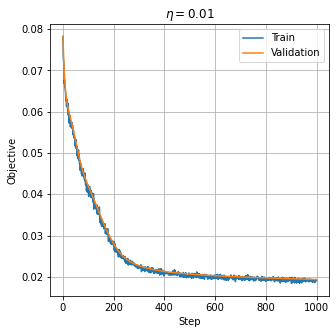

In [48]:
def train(model, eta, n_epochs, train_loader, x_val):
    ## Move validation set to the GPU
    x_val = x_val.cuda()
    
    ## Initizalie the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=eta)

    ## Prepare lists to store intermediate obejectives
    train_objective_list = [np.inf]
    val_objective_list = [np.inf]
    
    ## Run for n_epochs
    for epoch in tqdm.tqdm(range(n_epochs)):
        ## Run over the batches
        for x in train_loader:

            ## Move batch to GPU
            x = x[0].cuda()
            
            optimizer.zero_grad()
            ## Forward pass
            x_hat = model(x)
            objective = torch.nn.functional.mse_loss(x_hat, x)
            ## Backward pass
            objective.backward()
            ## Preform the gradient descent step
            optimizer.step()
    
        ## Evaluate the objective on the validation set
        with torch.no_grad(): ## This tell PyTorch not to calculate the gradients to save time
            train_objective_list.append(objective.item())

            x_val_hat = model(x_val)
            objective = torch.nn.functional.mse_loss(x_val_hat, x_val)
            val_objective_list.append(objective.item())

    return train_objective_list, val_objective_list

## Test the train function
eta = 0.01
n_epochs = 1000
model = CNN_AE()
try:
  model = model.cuda()
except:
  print("No gpu found, using cpu")
train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                 torch.tensor(x_test).float())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective')
ax.legend();

In [49]:
train_objective_list[-1]

0.019103774800896645

In [50]:
x = torch.tensor(x_train).float()[1:2].cuda()
x_hat = model(x)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


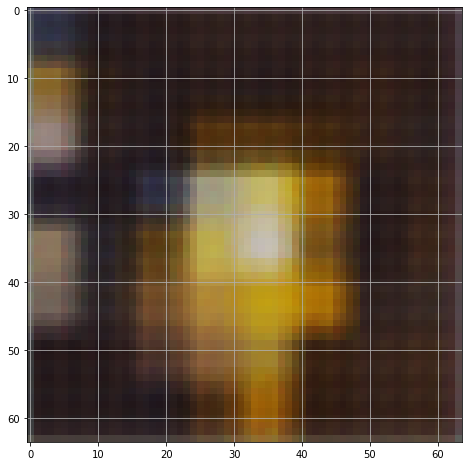

In [51]:
with torch.no_grad():
  plt.imshow(x_hat.cpu().numpy()[0])

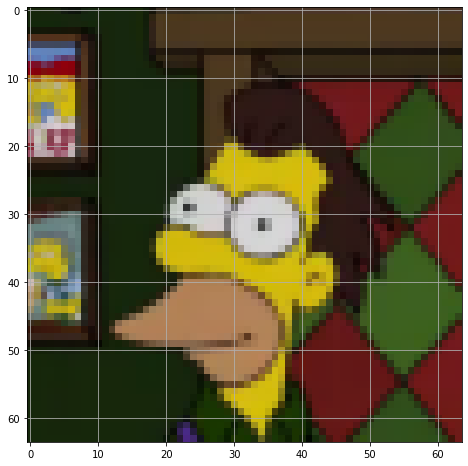

In [ ]:
with torch.no_grad():
  plt.imshow(x.cpu().numpy()[0])

In [ ]:
with torch.no_grad():
  print(x_hat.cpu().numpy()[0])

[[[0.5193085  0.4946734  0.36456123]
  [0.55577886 0.5175357  0.3216991 ]
  [0.55362386 0.5175042  0.32442358]
  ...
  [0.56070864 0.5175274  0.32077944]
  [0.5585311  0.5242573  0.32163575]
  [0.5277546  0.5338528  0.3483094 ]]

 [[0.5395121  0.48199627 0.35267767]
  [0.5758414  0.5078377  0.2972601 ]
  [0.5798398  0.51163346 0.29793343]
  ...
  [0.58456457 0.5142357  0.29381552]
  [0.5828091  0.5147915  0.29546654]
  [0.5367973  0.52072847 0.32647145]]

 [[0.5379836  0.47887197 0.3542861 ]
  [0.5799845  0.5091105  0.29374865]
  [0.5762186  0.509936   0.2992095 ]
  ...
  [0.58804864 0.5122564  0.29204312]
  [0.5852419  0.51932055 0.29618397]
  [0.5365852  0.521187   0.32496485]]

 ...

 [[0.54053485 0.48397717 0.35201252]
  [0.5782401  0.51031554 0.29703668]
  [0.5802356  0.5157458  0.29630518]
  ...
  [0.5858498  0.5175168  0.2961624 ]
  [0.5805797  0.51686436 0.29497916]
  [0.5376063  0.52149063 0.3267409 ]]

 [[0.5392696  0.4790251  0.35142234]
  [0.57530826 0.5083205  0.29649273]


### Selecting the learning rate

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

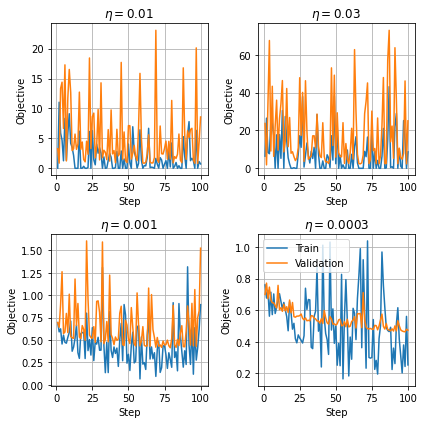

In [ ]:
n_epochs = 100
etas_list = (1e-2, 3e-2, 1e-3, 3e-4)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i_eta, eta in enumerate(etas_list):
    model = LinearLogisticRegression(in_features=x_train.shape[1] * x_train.shape[2] * x_train.shape[3], out_features=2)
    model = model.cuda()
    train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                     torch.tensor(x_val).float(),
                                                     torch.tensor(y_val).long())

    ## Plot
    ax = axes.flat[i_eta]
    ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
    ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
    ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
    ax.set_xlabel('Step')
    ax.set_ylabel('Objective')
axes[1,1].legend()
fig.tight_layout()

Selecting the largest learning rate $\eta$


  0%|          | 0/200 [00:00<?, ?it/s]

(0.0, 0.5)

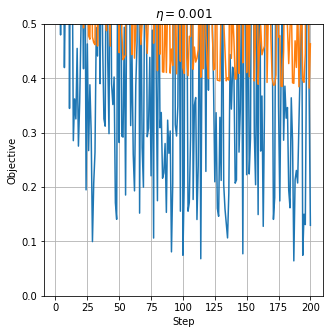

In [ ]:
eta = 0.001
n_epochs = 200
model = LinearLogisticRegression(in_features=x_train.shape[1] * x_train.shape[2] * x_train.shape[3], out_features=2)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                 torch.tensor(x_val).float(),
                                                 torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective')
ax.set_ylim(0, 0.5)


### Early Stopping

We would like to stop the training when the validation objective reaches its minimum.

199


  0%|          | 0/199 [00:00<?, ?it/s]

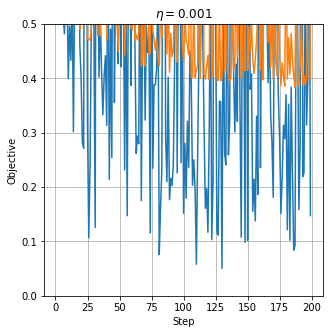

In [ ]:
optimal_number_of_steps = np.argmin(val_objective_list)
print(optimal_number_of_steps)

model = LinearLogisticRegression(in_features=x_train.shape[1] * x_train.shape[2] * x_train.shape[3], out_features=2)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, optimal_number_of_steps, train_loader,
                                                 torch.tensor(x_val).float(),
                                                 torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective')
ax.set_ylim(0, 0.5);

### Evaluating the Model on the Test Set

The following code calculates the misclassification rate on the test set.

In order to so we will define a data loader on the test set.

In [ ]:
test_set = torch.utils.data.TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).long())
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size)

## Evaluate the score on the test set
with torch.no_grad():
    test_score_list = []
    for x, y in test_loader:
        x = x.cuda()
        y = y.cuda()

        y_hat = model(x)
        test_score = (torch.argmax(y_hat, dim=1) != y).sum()

        test_score_list.append(test_score.item())

test_score_llr = np.sum(test_score_list) / len(test_set)

print(f'Linear Logistic Regression test score is: {test_score_llr:.3}')

Linear Logistic Regression test score is: 0.187


## MLP

Now that we have a training function and we know have some naive model we can try a bit more complex models.

Specifically, we will run one MLP network and one CNN network.

I.e., build a network with of the following layers:

- **fc1**: A fully connected (linear) layer with an input of the in_features and output of 1024 with a ReLU activation.
- **fc2**: A fully connected of 1024x1024 + ReLU.
- **fc3**: A fully connected of 1024xout_features.
- A softmax function

In our case:

- in_features = 64*64*3
- out_features = 2

We will use the function [**torch.nn.functional.relu**](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu) to implement the ReLU activation.

  0%|          | 0/50 [00:00<?, ?it/s]

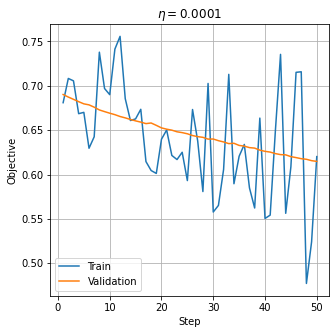

In [ ]:
class MLP(torch.nn.Module):

    def __init__(self, in_features, out_features):   
        super(MLP, self).__init__()
        
        ## Defining the fully connected (linear) layers with their parameters
        ## ==================================================================
        self.linear1 = torch.nn.Linear(in_features=in_features, out_features=1024, bias=True)
        # self.linear2 = torch.nn.Linear(in_features=1024, out_features=1024, bias=True)
        self.linear2 = torch.nn.Linear(in_features=1024, out_features=out_features, bias=True)
    
    def forward(self, x):
        x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        z = self.linear1(x)
        z = torch.nn.functional.relu(z)
        z = self.linear2(z)
        # z = torch.nn.functional.relu(z)
        # z = self.linear3(z)
        y = torch.nn.functional.log_softmax(z, dim=1)
        
        return y

## Test the train function
eta = 0.0001
n_epochs = 50
model = MLP(in_features=x_train.shape[1] * x_train.shape[2] * x_train.shape[3], out_features=2)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                 torch.tensor(x_val).float(),
                                                 torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective');
ax.legend()

### Selecting the learning rate

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/350 [00:00<?, ?it/s]

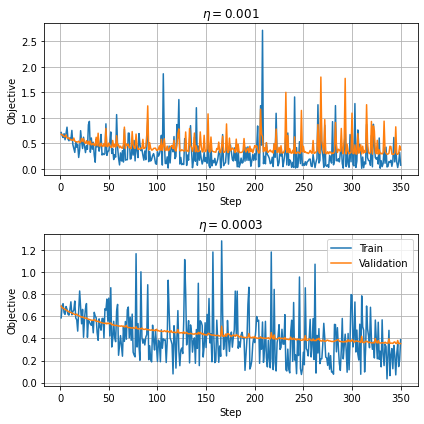

In [ ]:
n_epochs = 350
etas_list = (1e-3, 3e-4)

fig, axes = plt.subplots(2, 1, figsize=(6, 6))
for i_eta, eta in enumerate(etas_list):
    model = MLP(in_features=x_train.shape[1] * x_train.shape[2] * x_train.shape[3], out_features=2)
    model = model.cuda()
    train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                     torch.tensor(x_val).float(),
                                                     torch.tensor(y_val).long())
    
    ## Plot
    ax = axes.flat[i_eta]
    ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
    ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
    ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
    ax.set_xlabel('Step')
    ax.set_ylabel('Objective')
axes[1].legend()
fig.tight_layout()

We choose $\eta=3e-4$ and train the model for 500 epochs.

  0%|          | 0/500 [00:00<?, ?it/s]

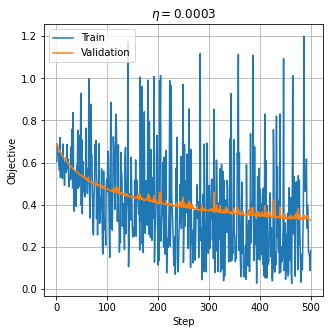

In [ ]:
eta = 3e-4
n_epochs = 500
model = MLP(in_features=x_train.shape[1] * x_train.shape[2] * x_train.shape[3], out_features=2)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                  torch.tensor(x_val).float(),
                                                  torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective')
ax.legend()

### Early Stopping

We would like to stop the training when the validation objective reaches its minimum.

498


  0%|          | 0/498 [00:00<?, ?it/s]

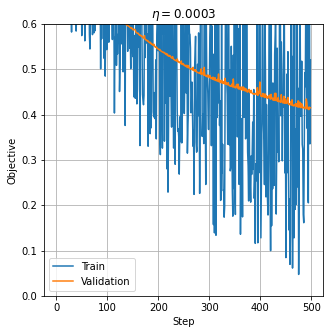

In [ ]:
optimal_number_of_steps = np.argmin(train_objective_list)
print(optimal_number_of_steps)
model = MLP(in_features=x_train.shape[1] * x_train.shape[2] * x_train.shape[3], out_features=2)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, optimal_number_of_steps, train_loader,
                                                  torch.tensor(x_val).float(),
                                                  torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective')
ax.set_ylim(0, 0.6);
ax.legend()

### Evaluating the Model on the Test Set

In [ ]:
with torch.no_grad():
    test_score_list = []
    for x, y in test_loader:
        x = x.cuda()
        y = y.cuda()

        y_hat = model(x)
        test_score = (torch.argmax(y_hat, dim=1) != y).sum()

        test_score_list.append(test_score.item())

test_score_mlp = np.sum(test_score_list) / len(test_set)

print(f'MLP Model test score is: {test_score_mlp:.3}')

MLP Model test score is: 0.145


## CNN

We will now also implement a CNN network.

In the code below we define a CNN which is composed of the following layers:

- **conv1**: A convolutional layer with a 3x3 kernel, 3 input channels, 64 output channels, a padding of 1 on each edge + ReLU.
- **conv2**: A convolutional layer with a 3x3 kernel, 64 input, 64 output, padding of 1, **stride of 2** + ReLU.
- **fc3**: A fully connected of (32\*32\*64)x256 + ReLU.
- **fc4**: A fully connected of 256x2.
- A softmax function

In [ ]:
class CNN(torch.nn.Module):

    def __init__(self, in_features, out_features):   
        super(CNN, self).__init__()
        
        ## Defining the convolutional and fully connected layers with their parameters
        ## ===========================================================================
        self.bn0 = torch.nn.BatchNorm2d(3)
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=2)
        self.fc3 = torch.nn.Linear(in_features=32*32*64, out_features=256)
        self.fc4 = torch.nn.Linear(in_features=256, out_features=out_features)
    
    def forward(self, x):
        x = x.transpose(1,3)
        z = self.bn0(x)
        z = self.conv1(z)
        z = torch.nn.functional.relu(z)
        z = self.conv2(z)
        z = torch.nn.functional.relu(z)
        z = z.view(z.shape[0], -1)
        z = self.fc3(z)
        z = torch.nn.functional.relu(z)
        z = self.fc4(z)
        y = torch.nn.functional.log_softmax(z, dim=1)
        return y

## Test the train function
eta = 0.001
n_epochs = 30
model = CNN(in_features=x_train.shape[1] * x_train.shape[2], out_features=2)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                 torch.tensor(x_val).float(),
                                                 torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective');

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

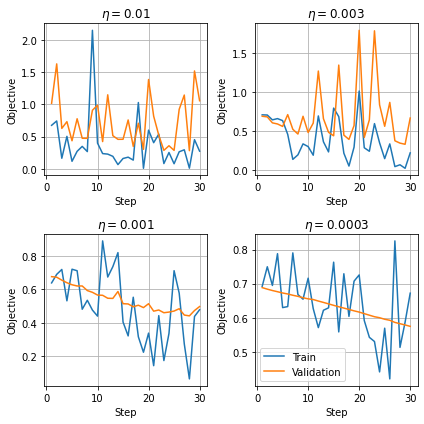

In [ ]:
nn_epochs = 30
etas_list = (0.01, 3e-3, 1e-3, 3e-4)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i_eta, eta in enumerate(etas_list):
    model = CNN(in_features=x_train.shape[1] * x_train.shape[2], out_features=2)
    model = model.cuda()
    train_objective_list, val_objective_list = train(model, eta, nn_epochs, train_loader,
                                                     torch.tensor(x_val).float(),
                                                     torch.tensor(y_val).long())
    
    ## Plot
    ax = axes.flat[i_eta]
    ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
    ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
    ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
    ax.set_xlabel('Step')
    ax.set_ylabel('Objective')
axes[1,1].legend()
fig.tight_layout()

Choosing $\eta=0.0003$

  0%|          | 0/398 [00:00<?, ?it/s]

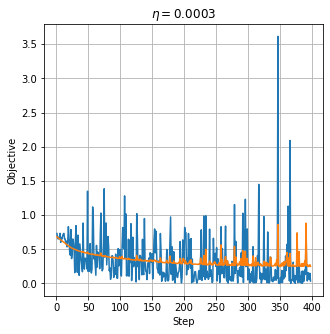

In [ ]:
batch_size = 128
train_set = torch.utils.data.TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).long())
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
eta = 0.0003
n_epochs = 398
model = CNN(in_features=x_train.shape[1] * x_train.shape[2], out_features=2)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                  torch.tensor(x_val).float(),
                                                  torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective');

In [ ]:
optimal_number_of_steps = np.argmin(val_objective_list)
print(optimal_number_of_steps)

eta = 0.0003
n_epochs = optimal_number_of_steps
model = CNN(in_features=x_train.shape[1] * x_train.shape[2], out_features=2)
model = model.cuda()
train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                  torch.tensor(x_val).float(),
                                                  torch.tensor(y_val).long())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective');

NameError: ignored

In [ ]:
torch.save(model, "cnn_eyes_gender.pt")

In [ ]:
test_set = torch.utils.data.TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).long())
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size)
with torch.no_grad():
    test_score_list = []
    for x, y in test_loader:
        x = x.cuda()
        y = y.cuda()
        y_hat = model(x)
        test_score = (torch.argmax(y_hat, dim=1) != y).sum()

        test_score_list.append(test_score.item())

test_score_cnn = np.sum(test_score_list) / len(test_set)
torch.save(model, "./cnn_eyes_gender.pt")

print(f'CNN Model Test Score is: {test_score_cnn:.3}')

CNN Model Test Score is: 0.109


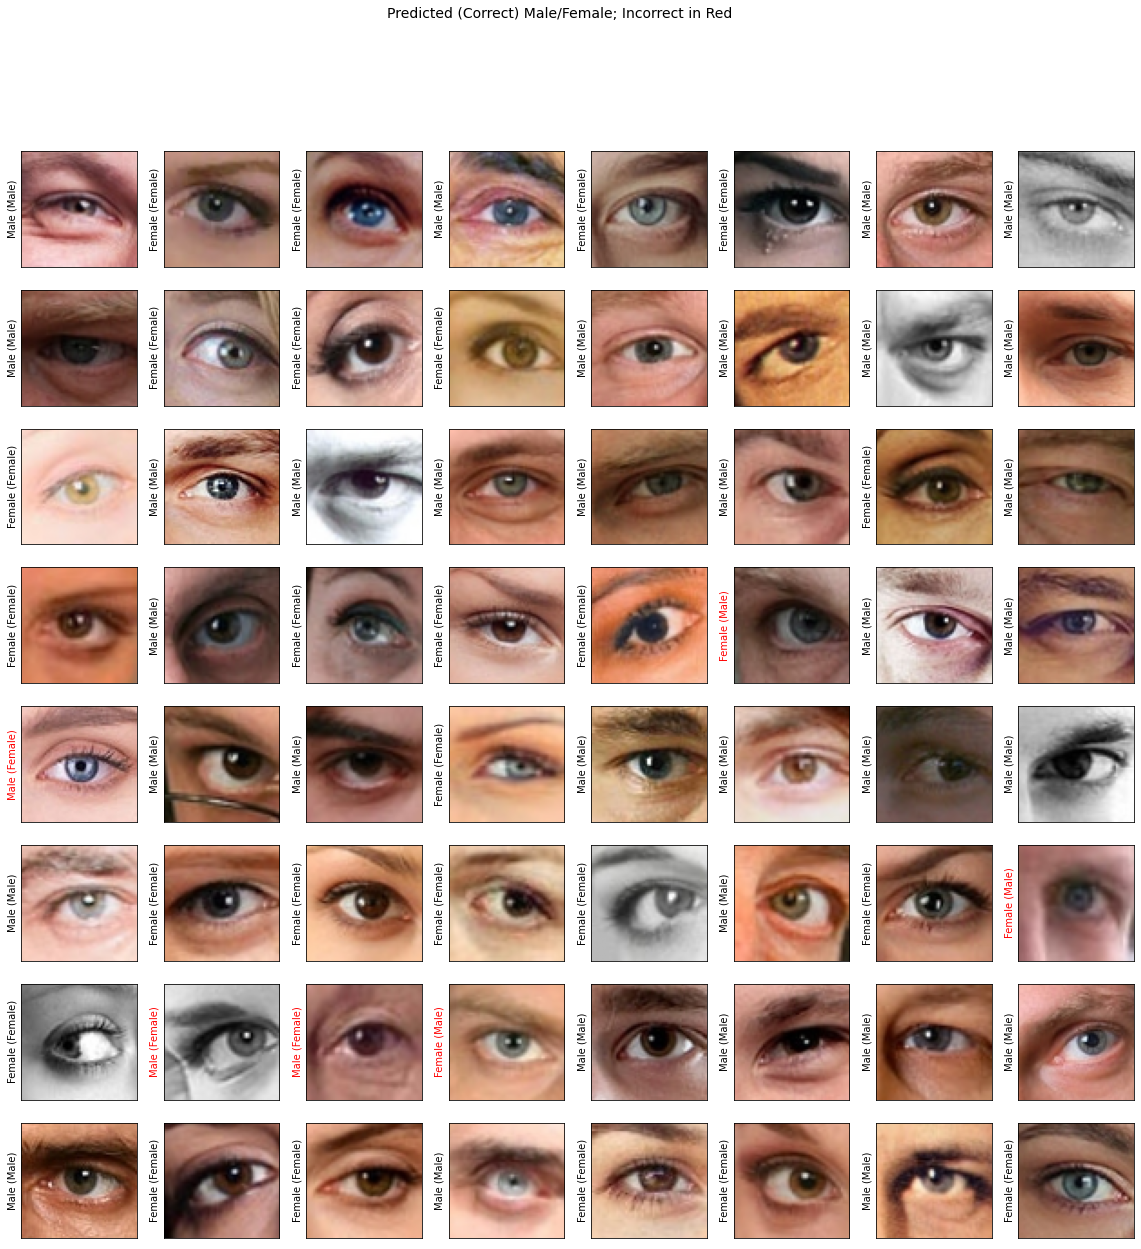

In [ ]:
## Plot the prediction
fig, ax_array = plt.subplots(8, 8, figsize=(20, 20))
for i, ax in enumerate(ax_array.flat):

    ax.imshow(x_test[i], cmap='gray')
    ax.set_yticks([])
    ax.set_xticks([])
    with torch.no_grad():
      y_hat = model(test_loader.dataset[i:i+1][0].cuda())
      y = test_loader.dataset[i][1].cuda()
      ax.set_ylabel(f'{"Female" if bool((torch.argmax(y_hat, dim=1).item()) == 1) else "Male"} ({"Female" if y.item() == 1 else "Male"})',
                     color='black' if bool((torch.argmax(y_hat, dim=1).item()) == (y.item())) else 'red')
fig.suptitle('Predicted (Correct) Male/Female; Incorrect in Red', size=14);

#Comparing The Models

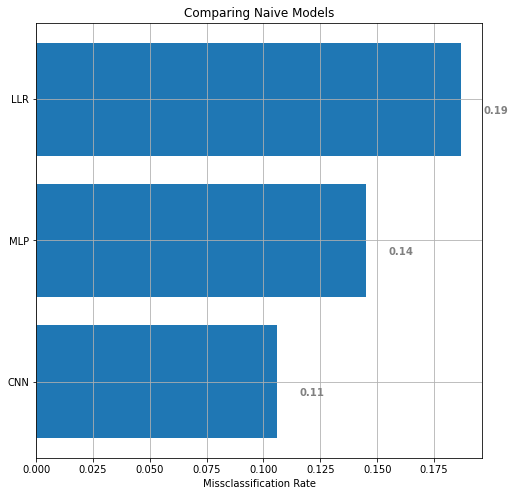

In [ ]:
fig, ax = plt.subplots()
hbars = ax.barh([0, 1, 2], [test_score_llr, test_score_mlp, test_score_cnn], align='center')
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(("LLR", "MLP", "CNN"))
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Missclassification Rate')
ax.set_title('Comparing Naive Models')

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.01, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.show()